In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from Perceptron import Perceptron
from VariableNet import VariableNet
from OneLayer import OneLayer
from TwoLayers import TwoLayers
from ThreeLayers import ThreeLayers
from FourLayers import FourLayers
from torch_utils import train_model, save_model, load_model, predictions
from utils import plot_results, cfm, filename, prediction_plots, prepareUnknown, QScanht,  plot  
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from gwpy.timeseries import TimeSeries
import seaborn as sns
torch.set_printoptions(sci_mode=False)

/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
!ls /data/gravwav/lopezm/Projects/GlitchBank/

boostrapped					     new_train_models
computational-aspects-of-machine-learning-project-3  sqlites
dataset_all_H1_bootstrap_O3a.npy		     train_models
data-visualization-and-optimisation		     unknown_data
LargeAnalysis					     Untitled.ipynb
new_boostrapped


In [153]:
!ls ../output_new/tw0.05/results/

95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches
95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batchesAcc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batchessummary.npy
95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.png
95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.pth
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batchesAcc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batchessummary.npy
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches.png
98.72Acc_H1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_2771epochs_10batches.pth
99.05Acc_V1_Th

In [25]:
def prepareKnown(tw, ifo, run):
    path_known = '/data/gravwav/lopezm/Projects/GlitchBank/new_boostrapped/tw'+str(tw)+'/'
    data_known = 'dataset_all_'+ifo+'_bootstrap_'+run+'.npy'
    data = np.load(path_known + data_known)
    df = pd.DataFrame(data, columns=['SNR', 'Chisq', 'Mass_1', 'Mass_2', 'Spin1z', 'Spin2z', 'Class'])
    return data[:, :-1], df

In [19]:
def prepareUnknown(tw, ifo):
    path_unknown = '/data/gravwav/lopezm/Projects/GlitchBank/unknown_data/'
    data_unknown = 'features_unknown_'+ifo+'_'+str(tw)+'.csv'
    times_unknown = 'times_unknown_'+ifo+'_'+str(tw)+'.csv'
    du = pd.read_csv(path_unknown + data_unknown)
    du = du.loc[:, ~du.columns.str.match('Unnamed')]
    dt = pd.read_csv(path_unknown + times_unknown)
    dt = dt.loc[:, ~dt.columns.str.match('Unnamed')]
    dt.columns = ['Cluster ID', 'Cluster time']
    display(du)
    data = du
    gpstimes = dt
    
    data_ = data.to_numpy()
    
    return data_, data, gpstimes

In [170]:
def QScanht(start, end, ifo):
    scratch = 2
    srate = 4096.
    background = TimeSeries.fetch_open_data(ifo,
                                            start-1,
                                            end+1,
                                            sample_rate=srate)
    #print(background.times[0] - background.times[-1])
    q_scan = background.q_transform(qrange=[4,64], frange=[10, 2048],
                              tres=0.002, fres=0.5, whiten=True)
    return q_scan

def plot(q_scan, start, end, gw190521=False):
    c = 'tomato'

    fig,ax = plt.subplots(dpi=120)
    #print(start, end, tmp_time)
    ax.imshow(q_scan[100:-100], cmap='viridis')
    ax.set_yscale('log', base=2)
    ax.set_xscale('linear')
    ax.set_ylabel('Frequency (Hz)', fontsize=14)
    ax.set_xlabel('Time (s)', labelpad=0.1,  fontsize=14)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(axis ='both', which ='major', labelsize = 14)
    ax.axvline(start, c='tomato', label=r'$t_{min}$', linewidth=1, alpha=0.8)
    ax.axvline(end, c='orchid', label=r'$t_{max}$', linewidth=1, alpha=0.8)
    #ax.axvline(tmp_time, c='crimson', label=r'$t_{cluster}$', linewidth=1, alpha=0.8)
    cb = ax.colorbar(label='Normalized energy',clim=[0, 25.5])
    if gw190521:
        ax.axvline(1242442967.4, c='black', label=r'$GW190521$', linewidth=1, alpha=0.8)
    #ax2.legend(bbox_to_anchor=(0.5, 1.2), ncol=3)
    plt.tight_layout()
    plt.show()

In [171]:
d_.shape

(301700, 6)

In [172]:
tw = 0.05
ifo = 'L1'
run = 'O3b'
# Call models
model = load_model(tw, ifo)

# Prepare unknown data
#d_, d, t = prepareUnknown(tw, ifo)
d_, d = prepareKnown(tw, ifo, run)
print(d_)
# Predict
ypred, label_pred = predictions(d_, model)

for i in range(ypred.shape[1]):
    d['Prob'+str(i)] = ypred[:, i]

#d.join(t)
#d.to_csv('/data/gravwav/lopezm/Projects/GlitchBank/computational-aspects-of-machine-learning-project-3/output_new/tw'+str(tw)+'/predictions/pred_unknown_'+ifo+'.csv')

95.42Acc_L1_ThreeLayers350_350_350Units_ReLU_CrossEntropyLoss_Adam_0.001lr_3505epochs_10batches.pth
[[ 1.01015909e+01  3.79381743e+00  2.64467755e+02
   5.15920745e+01 -4.29871518e-01  3.13131132e-01]
 [ 8.83492711e+00  2.76965906e+00  5.63385176e+01
   9.78657638e+00 -3.47713545e-01 -4.65877280e-01]
 [ 1.08035776e+02  2.98312994e+02  6.10214243e+01
   2.84666961e+01 -7.86403123e-01 -7.53428998e-01]
 ...
 [ 2.08083658e+01  4.67954073e+01  9.49114383e+01
   1.52809574e+01 -7.79249867e-01  1.10432724e-01]
 [ 5.56701140e+00  8.84931920e-01  4.16400450e+01
   1.14839920e+01  3.95556090e-01 -2.91355760e-01]
 [ 6.32421717e+01  1.52126808e+02  6.69399439e+01
   2.55391394e+01 -5.38404935e-01 -5.82369536e-01]]


In [173]:
pH1 = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_H1.csv')
pH1 = pH1.loc[:, ~pH1.columns.str.match('Unnamed')]

pL1 = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_L1.csv')
pL1 = pL1.loc[:, ~pL1.columns.str.match('Unnamed')]

pV1 = pd.read_csv('../output_new/tw0.05/predictions/pred_unknown_V1.csv')
pV1 = pV1.loc[:, ~pV1.columns.str.match('Unnamed')]

In [174]:
pH1_ = pH1[(pH1['Cluster time'] > 1242442967.4 -20000) & (pH1['Cluster time'] < 1242442967.4 +20000)]
pL1_ = pL1[(pL1['Cluster time'] > 1242442967.4 -20000) & (pL1['Cluster time'] < 1242442967.4 +20000)]


display(pH1_)
display(pL1_)

,SNR,Chisq,Mass_1,Mass_2,Spin1z,Spin2z,Prob0,Prob1,Prob2,Prob3,Prob4,Prob5,Prob6,Cluster ID,Cluster time
335929,5.504354,1.216764,42.242497,9.939208,0.937476,0.696860,1.082480e-10,1.052800e-10,5.226650e-30,1.936347e-10,0.0,1.000000e+00,0.000000e+00,54037.0,1.242423e+09
335930,4.156702,0.996336,45.039787,9.269236,-0.273304,-0.602280,9.999999e-01,1.060037e-08,0.000000e+00,1.124358e-07,0.0,6.075111e-09,4.718191e-23,54038.0,1.242423e+09
335931,4.370801,0.962821,45.105320,5.185626,0.918203,0.152546,3.243274e-04,3.456977e-14,3.705483e-34,9.996580e-01,0.0,1.758542e-05,0.000000e+00,54039.0,1.242423e+09
335932,4.094262,0.887941,62.461687,8.379415,0.340383,-0.058243,9.721509e-01,7.881263e-13,0.000000e+00,2.784912e-02,0.0,1.761255e-11,6.600000e-44,54040.0,1.242423e+09
335933,4.337716,0.571162,74.076344,8.179716,0.907492,-0.452376,9.433743e-01,3.368044e-24,0.000000e+00,5.660635e-02,0.0,1.936235e-05,0.000000e+00,54041.0,1.242423e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340965,4.493062,0.820702,86.340820,15.599413,0.169537,0.448864,9.969866e-01,7.596123e-28,0.000000e+00,2.989653e-03,0.0,2.376140e-05,0.000000e+00,59073.0,1.242463e+09
340966,4.497471,1.325740,45.466864,5.293616,0.885530,-0.904661,4.592817e-01,4.598828e-06,1.317823e-31,2.879719e-01,0.0,2.527417e-01,0.000000e+00,59074.0,1.242463e+09
340967,4.384796,1.203124,47.721353,5.130854,0.839365,0.173528,6.589727e-01,3.154809e-09,9.763908e-31,3.399861e-01,0.0,1.041273e-03,0.000000e+00,59075.0,1.242463e+09
340968,4.166672,1.019102,60.245678,8.223622,0.969807,-0.464231,4.066563e-02,5.351950e-08,0.000000e+00,9.593343e-01,0.0,3.583359e-10,0.000000e+00,59076.0,1.242463e+09


,SNR,Chisq,Mass_1,Mass_2,Spin1z,Spin2z,Prob0,Prob1,Prob2,Prob3,Prob4,Prob5,Prob6,Cluster ID,Cluster time
384873,5.622396,1.041820,45.487095,4.604047,0.722643,0.365065,0.001476,4.811026e-07,4.598425e-26,1.467105e-05,2.982435e-37,4.012014e-01,5.973077e-01,62424.0,1.242423e+09
384874,5.741000,1.699530,45.256087,5.282516,0.529506,-0.498580,0.155460,3.862296e-10,4.039130e-36,8.008645e-06,0.000000e+00,8.369589e-01,7.572788e-03,62425.0,1.242423e+09
384875,4.141871,0.843057,42.487926,9.786650,0.930597,0.647409,0.020874,7.528163e-22,1.284175e-27,9.791264e-01,1.058950e-38,3.854459e-26,3.399623e-14,62426.0,1.242423e+09
384876,7.115142,1.334111,381.381559,121.817170,0.780623,0.313523,0.673982,0.000000e+00,1.503164e-37,0.000000e+00,7.780454e-15,0.000000e+00,3.260182e-01,62427.0,1.242423e+09
384877,4.094980,1.330729,45.105320,5.185626,0.918203,0.152546,1.000000,5.223259e-12,7.893690e-21,9.156301e-13,0.000000e+00,2.573053e-11,2.756405e-15,62428.0,1.242423e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389964,4.433145,0.911486,44.128219,6.326831,0.866702,0.155271,0.997979,1.006534e-25,1.060241e-23,1.638180e-12,2.266520e-40,3.329493e-04,1.688237e-03,67515.0,1.242463e+09
389965,5.420474,1.058898,86.340820,15.599413,0.169537,0.448864,1.000000,2.488409e-16,2.198141e-32,6.059787e-21,6.573909e-14,7.230000e-43,6.775479e-17,67516.0,1.242463e+09
389966,5.408497,1.004455,45.464382,5.293967,0.885566,-0.904601,1.000000,1.450758e-13,0.000000e+00,2.116804e-07,0.000000e+00,3.470595e-10,8.974009e-10,67517.0,1.242463e+09
389967,5.678319,0.714589,60.245678,8.223622,0.969807,-0.464231,0.001512,2.442570e-26,0.000000e+00,9.984880e-01,0.000000e+00,5.367314e-19,1.400124e-07,67518.0,1.242463e+09


In [175]:
def amazingStat2ifo(tmp_h1, tmp_l1):
    
    ph1 = tmp_h1['Prob0']
    pl1 = tmp_l1['Prob0'].values[0]
    snr_h1 = tmp_h1['SNR']
    snr_l1 = tmp_l1['SNR'].values[0]
    dt = np.abs(th1-tl1)
    dm1 = np.abs(tmp_h1['Mass_1'] - tmp_l1['Mass_1'].values[0])
    dm2 = np.abs(tmp_h1['Mass_2'] - tmp_l1['Mass_2'].values[0])
    sigma_m1 = 1
    sigma_m2 = 1
    sigma_snr = 2
    epsilon = 10**(-12)
    #As2ifo = np.log(ph1*pl1*np.exp((snr_h1 - snr_l1))*np.exp(np.abs(dt))*np.exp(- (dm1/sigma_m1) - (dm2/sigma_m2)))
    As2ifo = ph1*pl1*np.log(np.exp(np.abs(dt))*100 -dm1-dm2 + np.exp(snr_l1)+ np.exp(snr_h1))
    print(np.round(As2ifo, 3), ph1*pl1, np.log(np.exp(np.abs(dt))*1000+ np.exp(-dm1-dm2-epsilon) + np.exp((snr_h1+snr_l1)/sigma_snr)))
    
    #if np.abs(th1 - 1242442967.4) < 0.1:
    #    print('GW', As2ifo, ph1*pl1, np.log(np.exp(np.abs(dt))*1000+ np.exp(-dm1-dm2-epsilon) + np.exp((snr_h1+snr_l1)/sigma_snr)))
    #else:
    #    print(As2ifo, ph1*pl1, np.log(np.exp(np.abs(dt))*1000+ np.exp(-dm1-dm2-epsilon) + np.exp((snr_h1+snr_l1)/sigma_snr)))
    return th1, tl1, As2ifo

In [176]:
Th1, Tl1, As = list(), list(), list()
for i in range(len(pH1_)):
    tmp_h1 = pH1_.iloc[i]
    th1 = tmp_h1['Cluster time']
    tmp_l1 = pL1_[(pL1_['Cluster time'] > th1 -0.03) & (pL1_['Cluster time'] < th1 +0.03)]
    
    if len(tmp_l1) != 0:
        tl1 = tmp_l1['Cluster time'].values[0]
        #if (np.asarray(tmp_h1['Prob0']) > 0.9) and (np.asarray(tmp_l1['Prob0'].values[0]) > 0.9):

        ph1 = tmp_h1['Prob0']
        pl1 = tmp_l1['Prob0'].values[0]
        snr_h1 = tmp_h1['SNR']
        snr_l1 = tmp_l1['SNR'].values[0]
        dt = np.abs(th1-tl1)
        dm1 = np.abs(tmp_h1['Mass_1'] - tmp_l1['Mass_1'].values[0])
        dm2 = np.abs(tmp_h1['Mass_2'] - tmp_l1['Mass_2'].values[0])
        sigma_m1 = 2
        sigma_m2 = 2

        th1, tl1, stat = amazingStat2ifo(tmp_h1, tmp_l1)
        #if stat < -50:
        #print(th1 - tl1, stat)
        #q_scan = QScanht(th1-2, th1+2, 'H1')
        #plot(q_scan, th1-2, th1, th1+2)

        #q_scan = QScanht(tl1-2, tl1+2, 'L1')
        #plot(q_scan, tl1-2,tl1, tl1+2)
#print(th1 - tl1)

0.0 2.2595160274631106e-12 7.033192710926198
5.234 0.94337434 6.984717772291536
3.836 0.69710945582173 6.98495725081481
1.025 0.1884005621757732 6.981106402059254
5.185 0.95250046 6.98624895692017
0.009 0.0015603048999999999 6.9951478538699705
0.364 0.0580529575311673 7.071835682677933
0.0 8.7755316035694e-11 7.061277224285563
5.329 0.98429686 6.976210785642702
5.529 0.9064364481149704 7.064118065255548
0.008 0.0013340119941568 7.046660285466144
0.0 8.4910374e-05 6.9750604069283035
0.031 0.00573181848772425 6.984191443814254
0.144 0.0258413350776936 6.99584751383311
5.398 1.0 6.983770393217218
1.396 0.25465593 6.988063922364331
4.503 0.72977756450019 7.059179095761862
5.332 0.99355847 6.9764870015812805
0.128 0.022159225401437617 7.020821447667024
0.302 0.055584755 6.985111954898549
4.207 0.68353325 7.062813904380752
5.546 0.9989795001020401 6.999902848880574
5.644 0.99955624 7.0097508527715915
0.019 0.0035442205 6.979761961228617
5.632 0.9967553584800241 7.002426238090282
0.002 0.0003

/data/gravwav/lopezm/cmb_env/miniforge3/envs/ml_course/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


3.91 0.7141345 6.986215251926143
5.631 1.0 7.005210868270254
0.001 0.00020946186999999997 6.9930462686007875
5.079 0.9295278994507999 6.9894423725075905
0.066 0.012297219 6.973826009094931
0.0 4.329282355782861e-06 6.99878910862474
0.213 0.038858343 6.982131157552512
5.465 0.9982999118548239 6.98191763594071
6.174 1.0 7.071449019136888
1.029 0.190280268286548 6.983475595694613
6.186 0.99998856 7.08253800049595
5.275 0.955926 6.982119373397542
0.0 2.73627355260916e-10 7.071769166732423
0.093 0.01675977516675075 7.004962601910724
0.027 0.004848405666747899 6.993236682947657
5.095 0.8632977523997881 7.038006603111162
4.743 0.8624440859252401 6.978452701512773
3.419 0.62920225 6.974328510765233
5.098 0.94586647 6.973075689597031
5.421 0.9999998999999999 6.980755283285908
0.087 0.015352697847017219 6.996774648190493
0.0 9.712161358098603e-16 6.98117914440651
2.697 0.5010963788893441 6.9782473631628354
0.002 0.00029489966 7.0389909438716245
0.131 0.021199338412084538 7.0963503374430275
0.064

In [177]:
display(pH1.loc[i].values)
print(pH1.columns.values)
pd.DataFrame(pH1.loc[i].values.reshape(1, -1), columns=pH1.columns)

array([ 5.12206320e+00,  9.55382530e-01,  3.94408340e+01,
        1.12026970e+01, -2.82003310e-01, -3.86371310e-01,
        9.51180300e-04,  6.55757500e-02,  3.34000000e-43,
        5.04718660e-10,  0.00000000e+00,  9.33473050e-01,
        2.93718530e-35,  5.04000000e+03,  1.23820792e+09])

['SNR' 'Chisq' 'Mass_1' 'Mass_2' 'Spin1z' 'Spin2z' 'Prob0'
 'Prob1' 'Prob2' 'Prob3' 'Prob4' 'Prob5' 'Prob6' 'Cluster ID'
 'Cluster time']


,SNR,Chisq,Mass_1,Mass_2,Spin1z,Spin2z,Prob0,Prob1,Prob2,Prob3,Prob4,Prob5,Prob6,Cluster ID,Cluster time
0,5.122063,0.955383,39.440834,11.202697,-0.282003,-0.386371,0.000951,0.065576,3.340000e-43,5.047187e-10,0.0,0.933473,2.937185e-35,5040.0,1.238208e+09


In [ ]:
tmp = pd.concat([tmp_h1, tmp_l1], axis=1)
tmp_h1.join(tmp_l1, lsuffix="_H1", rsuffix=("_L1"))


In [179]:
Th1, Tl1, As = list(), list(), list()
columns = pH1.columns
all_rows = list()
for i in range(len(pH1_)):
    tmp_h1 = pH1_.iloc[[i]].reset_index()
    th1 = tmp_h1['Cluster time'].values[0]
    tmp_l1 = pL1_[(pL1_['Cluster time'] > th1 -0.03) & (pL1_['Cluster time'] < th1 +0.03)].reset_index()
    
    if len(tmp_l1) != 0:
        tmp = tmp_h1.join(tmp_l1, lsuffix="_H1", rsuffix=("_L1"))
        all_rows.append(tmp.values[0])

In [180]:
merged = pd.DataFrame(all_rows, columns=tmp.columns)
gw190521 = merged[(merged['Cluster time_H1'] > 1242442967.4 -1) & (merged['Cluster time_H1'] < 1242442967.4 +1)]

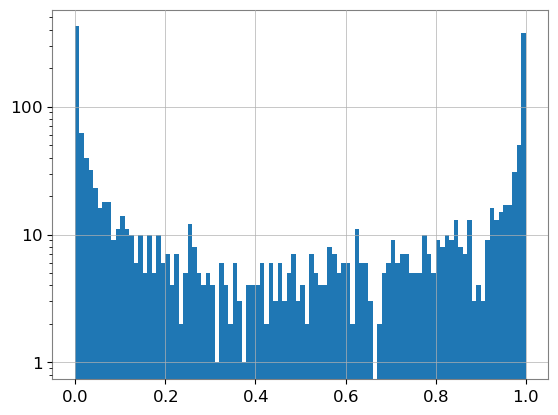

In [185]:
plt.hist(merged['Prob0_H1'], bins=100)
plt.yscale('log')

(array([ 24., 111., 216., 233., 257., 269., 246., 212.,  87.,
         16.]),
 array([-0.02910447, -0.02321193, -0.01731939, -0.01142685,
        -0.00553432,  0.00035822,  0.00625076,  0.0121433 ,
         0.01803584,  0.02392838,  0.02982092]),
 <BarContainer object of 10 artists>)

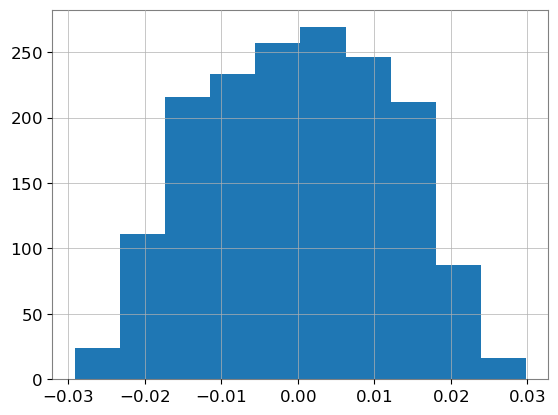

In [181]:
plt.hist(merged['Cluster time_H1']-merged['Cluster time_L1'])

In [186]:

ds1 = np.abs(merged['Spin1z_H1']-merged['Spin1z_L1'])
ds2 = np.abs(merged['Spin2z_H1']-merged['Spin2z_L1'])
dm1 = np.abs(merged['Mass_1_H1']-merged['Mass_1_L1'])
dm2 = np.abs(merged['Mass_2_H1']-merged['Mass_2_L1'])
dt = np.abs(merged['Cluster time_H1']-merged['Cluster time_L1'])
ph1 = merged['Prob0_H1']
pl1 = merged['Prob0_L1']
netSNR = np.sqrt(merged['SNR_H1']**2 +merged['SNR_L1']**2)
netChisq = np.sqrt(merged['Chisq_H1']**2+merged['Chisq_L1']**2)

ds1gw = np.abs(gw190521['Spin1z_H1']-gw190521['Spin1z_L1'])
ds2gw = np.abs(gw190521['Spin2z_H1']-gw190521['Spin2z_L1'])
dm1gw = np.abs(gw190521['Mass_1_H1']-gw190521['Mass_1_L1'])
dm2gw = np.abs(gw190521['Mass_2_H1']-gw190521['Mass_2_L1'])
dtgw = np.abs(gw190521['Cluster time_H1']-gw190521['Cluster time_L1'])
ph1gw = gw190521['Prob0_H1']
pl1gw = gw190521['Prob0_L1']
netSNRgw = np.sqrt(gw190521['SNR_H1']**2 + gw190521['SNR_L1']**2)
netChisqgw = np.sqrt(gw190521['Chisq_H1']**2+gw190521['Chisq_L1']**2)


merged.columns

Index(['index_H1', 'SNR_H1', 'Chisq_H1', 'Mass_1_H1', 'Mass_2_H1', 'Spin1z_H1',
       'Spin2z_H1', 'Prob0_H1', 'Prob1_H1', 'Prob2_H1', 'Prob3_H1', 'Prob4_H1',
       'Prob5_H1', 'Prob6_H1', 'Cluster ID_H1', 'Cluster time_H1', 'index_L1',
       'SNR_L1', 'Chisq_L1', 'Mass_1_L1', 'Mass_2_L1', 'Spin1z_L1',
       'Spin2z_L1', 'Prob0_L1', 'Prob1_L1', 'Prob2_L1', 'Prob3_L1', 'Prob4_L1',
       'Prob5_L1', 'Prob6_L1', 'Cluster ID_L1', 'Cluster time_L1'],
      dtype='object')

1094    0.691108
dtype: float64


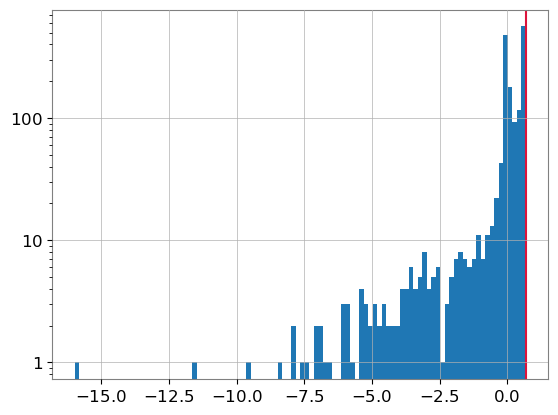

In [187]:
def amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq):
    epsilon =10**(-12)
    #ams = np.log((ph1*pl1)/2*np.exp(-ds1-ds2-dm1-dm2-dt+netSNR))
    ams = np.log(pl1+ph1)
    #ams = (ph1*pl1*np.exp(-dt+netSNR-(ds1+ds2+epsilon)/2-(dm1 +dm2+epsilon)/2+netChisq))
    return ams

print(amazingStat(ds1gw, ds2gw, dm1gw, dm2gw, dtgw, ph1gw, pl1gw, netSNRgw, netChisqgw))
plt.hist(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq).values, bins=100)
plt.axvline(amazingStat(ds1gw, ds2gw, dm1gw, dm2gw, dtgw, ph1gw, pl1gw, netSNRgw, netChisqgw).values, c='crimson')
plt.yscale('log')


In [196]:
merged['SNR_L1']

0       4.141871
1       4.385252
2       4.101066
3       4.167203
4       4.094711
          ...   
1666    4.417823
1667    5.181598
1668    4.433145
1669    5.408497
1670    4.659464
Name: SNR_L1, Length: 1671, dtype: float64

In [206]:
merged

,index_H1,SNR_H1,Chisq_H1,Mass_1_H1,Mass_2_H1,Spin1z_H1,Spin2z_H1,Prob0_H1,Prob1_H1,Prob2_H1,...,Spin2z_L1,Prob0_L1,Prob1_L1,Prob2_L1,Prob3_L1,Prob4_L1,Prob5_L1,Prob6_L1,Cluster ID_L1,Cluster time_L1
0,335929.0,5.504354,1.216764,42.242497,9.939208,0.937476,0.696860,1.082480e-10,1.052800e-10,5.226650e-30,...,0.647409,0.020874,7.528163e-22,1.284175e-27,9.791264e-01,1.058950e-38,3.854459e-26,3.399623e-14,62426.0,1.242423e+09
1,335933.0,4.337716,0.571162,74.076344,8.179716,0.907492,-0.452376,9.433743e-01,3.368044e-24,0.000000e+00,...,-0.445660,1.000000,1.724178e-22,4.841650e-37,3.444925e-19,0.000000e+00,1.157837e-37,1.460092e-09,62432.0,1.242423e+09
2,335940.0,4.431832,0.779133,52.862414,5.686511,-0.918176,0.054993,7.037326e-01,6.222820e-24,1.000000e-45,...,0.054713,0.990589,1.657566e-12,4.280655e-15,9.409504e-03,5.694222e-32,0.000000e+00,1.905000e-06,62441.0,1.242423e+09
3,335942.0,4.177088,1.183540,83.740386,10.077686,0.866274,0.570191,1.884006e-01,1.057721e-24,2.333606e-38,...,0.566264,1.000000,4.360502e-15,3.470730e-31,9.291057e-09,1.405185e-27,2.504373e-27,3.362249e-07,62442.0,1.242423e+09
4,335943.0,4.242392,1.185355,73.949013,10.798553,0.979575,-0.969314,9.525005e-01,6.776906e-03,0.000000e+00,...,-0.969314,1.000000,3.190380e-32,0.000000e+00,3.749617e-18,0.000000e+00,1.380338e-27,2.347520e-11,62443.0,1.242423e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,340960.0,5.502688,0.870507,56.644993,6.525756,0.969895,-0.795147,6.784990e-02,4.852498e-11,1.453236e-39,...,-0.795147,1.000000,1.510665e-11,0.000000e+00,1.331121e-16,0.000000e+00,1.117761e-08,9.204244e-09,67509.0,1.242462e+09
1667,340962.0,5.178270,0.998766,47.378820,8.715445,-0.695802,-0.245646,9.997788e-01,6.090972e-07,1.066000e-42,...,-0.246502,1.000000,7.622361e-22,0.000000e+00,1.537342e-28,6.327377e-32,0.000000e+00,8.968101e-19,67513.0,1.242462e+09
1668,340964.0,5.483469,1.096538,44.125382,6.327168,0.866262,0.161709,2.577026e-01,7.243213e-13,6.172498e-27,...,0.155271,0.997979,1.006534e-25,1.060241e-23,1.638180e-12,2.266520e-40,3.329493e-04,1.688237e-03,67515.0,1.242463e+09
1669,340966.0,4.497471,1.325740,45.466864,5.293616,0.885530,-0.904661,4.592817e-01,4.598828e-06,1.317823e-31,...,-0.904601,1.000000,1.450758e-13,0.000000e+00,2.116804e-07,0.000000e+00,3.470595e-10,8.974009e-10,67517.0,1.242463e+09


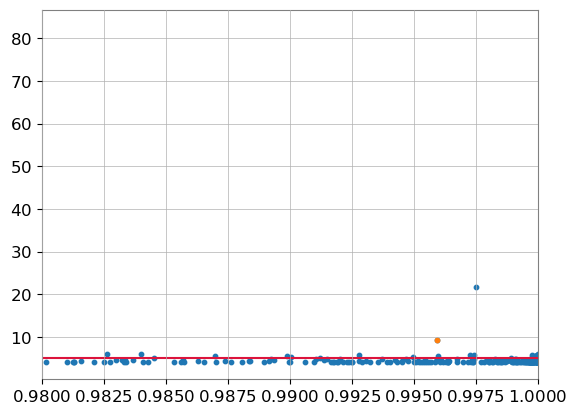

In [199]:
plt.scatter(ph1*pl1, merged['SNR_L1'], s=10)
plt.scatter(ph1gw*pl1gw, gw190521['SNR_L1'], s=10)
plt.xlim(0.98, 1)
#plt.ylim(0, 20)
plt.axhline(5, c='crimson')
#plt.xscale('log')
#plt.yscale('log')

In [1179]:
ph1gw*pl1gw

1094    0.995926
dtype: float64

(array([559.,  70.,  44.,  33.,  18.,  16.,  20.,  17.,  13.,
          8.,   9.,  13.,  10.,   6.,  11.,   3.,  12.,   8.,
          6.,   6.,   9.,   4.,   5.,   3.,   5.,   9.,   6.,
          5.,   7.,   3.,   2.,   5.,   5.,   2.,   0.,   7.,
          6.,   0.,   4.,   5.,   3.,   7.,   3.,   3.,   3.,
          8.,   1.,   6.,   5.,   1.,   4.,   1.,   6.,   3.,
          4.,   5.,   8.,   8.,   7.,   5.,   4.,   5.,  10.,
          6.,   7.,   1.,   2.,   1.,   7.,   6.,   6.,   7.,
          8.,   5.,   5.,   3.,   3.,  10.,   0.,   5.,   7.,
         10.,   8.,   8.,  10.,   7.,   5.,   9.,   4.,   3.,
          4.,   8.,  16.,  11.,  12.,  13.,  16.,  28.,  39.,
        287.]),
 array([6.81726183e-36, 1.00000000e-02, 2.00000000e-02,
        3.00000000e-02, 4.00000000e-02, 5.00000000e-02,
        6.00000000e-02, 7.00000000e-02, 8.00000000e-02,
        9.00000000e-02, 1.00000000e-01, 1.10000000e-01,
        1.20000000e-01, 1.30000000e-01, 1.40000000e-01,
        1.50000000e-01

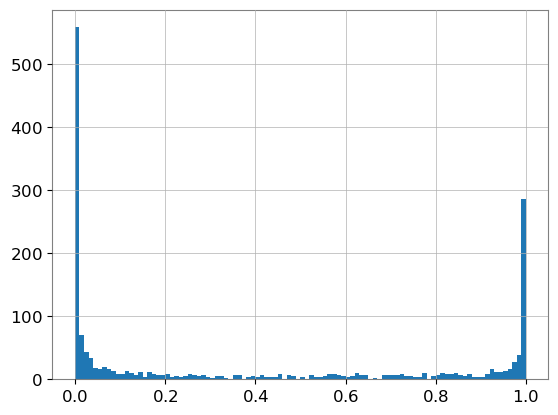

In [1174]:
plt.hist(ph1*pl1, bins=100)

In [1154]:
np.log(pl1gw*ph1gw)

1094   -0.004083
dtype: float64

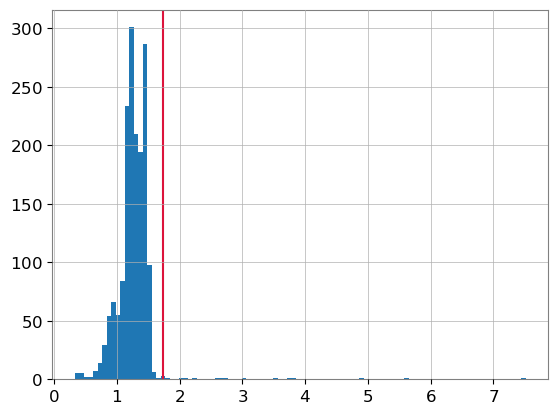

In [1141]:

plt.hist(np.log(pl1+ph1+netChisq + np.exp(-dm1-dm2-ds1-ds2)), bins=100)
plt.axvline(np.log(pl1gw+ph1gw+netChisqgw + np.exp(-dm1gw-dm2gw-ds1gw-ds2gw)).values, c='crimson')

In [1110]:
np.log(pl1gw*ph1gw + np.exp(-dm1gw-dm2gw-ds1gw-ds2gw)+netChisqgw).values, netChisqgw, netChisq[np.argmax(np.log(pl1*ph1 + np.exp(-dm1-dm2-ds1-ds2)+netChisq))]

(array([1.55001182]),
 1094    3.710678
 dtype: float64,
 1843.7926074433542)

In [1076]:
max(dm1)

400.26221254816517

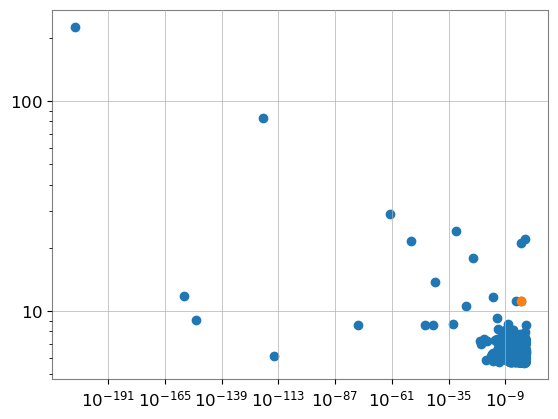

In [1070]:
plt.scatter(ph1*pl1*netChisq*np.exp(-ds1-dm1), netSNR)
plt.scatter(ph1gw*pl1gw*netChisqgw*np.exp(-ds1gw-dm1gw), netSNRgw)
plt.yscale('log')
plt.xscale('log')

In [1045]:
a = np.argmin(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq))
display(merged.iloc[[a]]['Prob0_H1'])
amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq).values.sum()

667    6.817387e-36
Name: Prob0_H1, dtype: float64

480.8597926121278

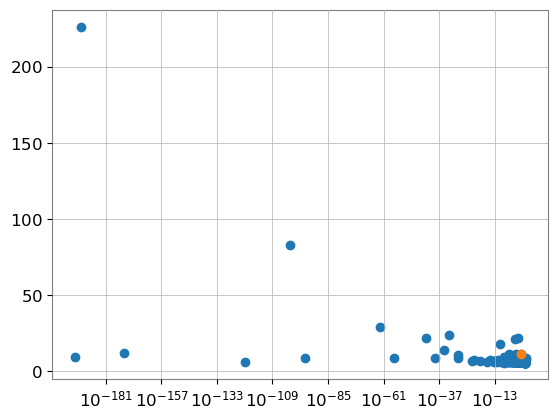

In [980]:
plt.scatter(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq), np.sqrt(merged['SNR_H1']**2+merged['SNR_L1']**2))
plt.scatter(amazingStat(ds1gw, ds2gw, dm1gw, dm2gw, dtgw, ph1gw, pl1gw, netSNRgw, netChisqgw), np.sqrt(gw190521['SNR_H1']**2+gw190521['SNR_L1']**2))
plt.xscale('log')

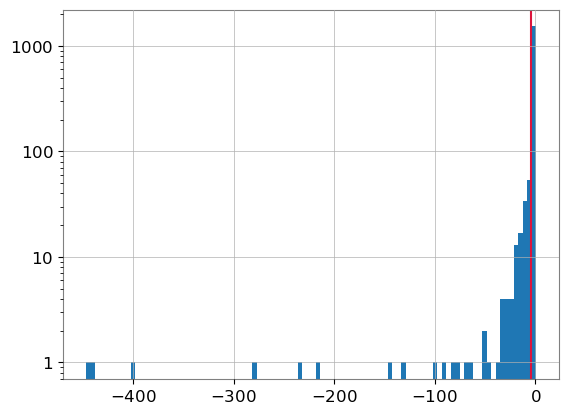

In [985]:
plt.hist(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR, netChisq).values, bins=100)
plt.axvline(amazingStat(ds1gw, ds2gw, dm1gw, dm2gw, dtgw, ph1gw, pl1gw, netSNRgw, netChisqgw).values, c='crimson')
plt.yscale('log')

In [662]:
np.argmax(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR))

68

In [670]:
merged.iloc[68]['Prob0_L1']

0.9839279000000001

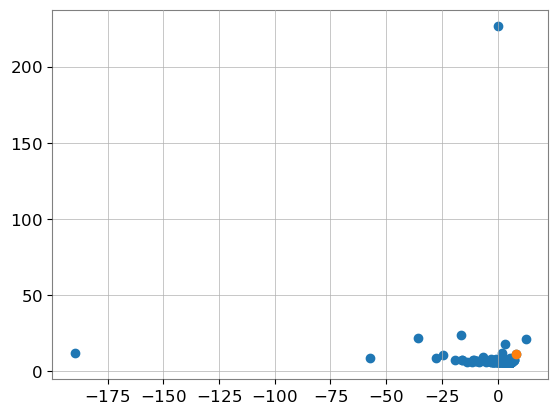

In [673]:
plt.scatter(amazingStat(ds1, ds2, dm1, dm2, dt, ph1, pl1, netSNR), np.sqrt(merged['SNR_H1']**2+merged['SNR_L1']**2))
plt.scatter(amazingStat(ds1gw, ds2gw, dm1gw, dm2gw, dtgw, ph1gw, pl1gw, netSNRgw), np.sqrt(gw190521['SNR_H1']**2+gw190521['SNR_L1']**2))
plt.

In [582]:
Th1, Tl1, As = list(), list(), list()
for i in range(10000):
    tmp_h1 = pH1.iloc[i]
    th1 = tmp_h1['Cluster time']
    tmp_l1 = pL1[(pL1['Cluster time'] > th1 -0.03) & (pL1['Cluster time'] < th1 +0.03)]
    
    if len(tmp_l1) != 0:
        tl1 = tmp_l1['Cluster time'].values[0]

        th1, tl1, stat = amazingStat2ifo(tmp_h1, tmp_l1)

        #if stat > 9:
        #    print(tmp_h1['Prob0'], tmp_l1['Prob0'].values[0])
        #    print(tmp_h1['SNR'], tmp_l1['SNR'].values[0])
        #    print(np.abs(tmp_h1['Mass_1'] - tmp_l1['Mass_1'].values[0]), np.abs(tmp_h1['Mass_2'] - tmp_l1['Mass_2'].values[0]))
        #    print(np.abs(th1-tl1))
        #    print(' ')

        #print(pH1.iloc[i]['Prob0'], ph1*pl1)
        #display(tmp_l1)

        #q_scan = QScanht(th1-2, th1+2, 'H1')
        #plot(q_scan, th1-2, th1, th1+2)

        #q_scan = QScanht(tl1-2, tl1+2, 'L1')
        #plot(q_scan, tl1-2,tl1, tl1+2)

        Th1.append(th1)
        Tl1.append(th1)
        As.append(stat)
        #if stat > 0:
        #print(th1 - tl1, stat)
        #q_scan = QScanht(th1-2, th1+2, 'H1')
        #plot(q_scan, th1-2, th1, th1+2)

        #q_scan = QScanht(tl1-2, tl1+2, 'L1')
        #plot(q_scan, tl1-2,tl1, tl1+2)
#print(th1 - tl1)

0.001 0.00013359569164780318 7.059087669686809
1.106 0.18427156 7.051156587535167
0.0 2.006096180805188e-09 6.9960879673373215
0.0 3.3910017186059696e-05 7.043981010854159
4.41 0.8091133 6.979860716461582
0.004 0.0006383971606899949 7.011331383048613
0.0 5.2249060888978005e-06 7.783322204402708
0.0 5.37759332027748e-06 7.073018141392847
0.002 0.000398969687973504 6.970954742326363
5.554 1.0 6.999373741991762
5.531 0.999730054170075 6.986651332460021
0.008 0.001544423034328944 6.980582712911048
0.0 1.2640736978564396e-08 6.9952249732368195
0.328 0.060720567 6.974622224388539
2.327 0.42798123 6.979153453961414
0.001 0.00023703258079413441 6.975404620909824
3.51 0.64219767 6.991002609009656
5.389 0.99999535 6.969934773809787
0.625 0.1157887284765909 6.972953701672525
5.443 0.9999899999999999 6.975664427686883
0.246 0.04485854 6.983221246366271
0.0 4.1209441346685004e-06 6.993283482611812
5.464 1.0 7.024403443031861
1.713 0.30211260255449995 7.012271645537434
0.0 5.48132143383552e-07 7.056

(array([1.769e+03, 7.750e+02, 2.440e+02, 6.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  2.7400914 ,  5.4801828 ,  8.2202742 ,
        10.9603656 , 13.700457  , 16.4405484 , 19.1806398 ,
        21.9207312 , 24.66082259, 27.40091399]),
 <BarContainer object of 10 artists>)

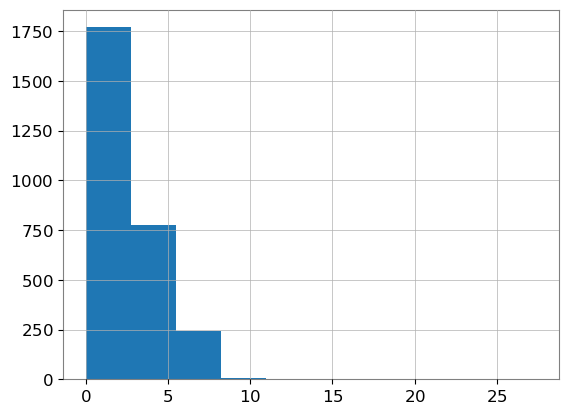

In [583]:
plt.hist(As)

In [314]:
Th1, Tl1, As = list(), list(), list()
for i in range(len(pH1_)):
    tmp_h1 = pH1_.iloc[i]
    th1 = tmp_h1['Cluster time']
    tmp_l1 = pL1_[(pL1_['Cluster time'] > th1 -0.03) & (pL1_['Cluster time'] < th1 +0.03)]
    
    if len(tmp_l1) != 0:
        tl1 = tmp_l1['Cluster time'].values[0]
        #if (np.asarray(tmp_h1['Prob0']) > 0.9) and (np.asarray(tmp_l1['Prob0'].values[0]) > 0.9):

        ph1 = tmp_h1['Prob0']
        pl1 = tmp_l1['Prob0'].values[0]
        snr_h1 = tmp_h1['SNR']
        snr_l1 = tmp_l1['SNR'].values[0]
        dt = np.abs(th1-tl1)
        dm1 = np.abs(tmp_h1['Mass_1'] - tmp_l1['Mass_1'].values[0])
        dm2 = np.abs(tmp_h1['Mass_2'] - tmp_l1['Mass_2'].values[0])
        sigma_m1 = 2
        sigma_m2 = 2

        th1, tl1, stat = amazingStat2ifo(tmp_h1, tmp_l1)
        #if stat < -50:
        print(th1 - tl1, stat)
        #q_scan = QScanht(th1-2, th1+2, 'H1')
        #plot(q_scan, th1-2, th1, th1+2)

        #q_scan = QScanht(tl1-2, tl1+2, 'L1')
        #plot(q_scan, tl1-2,tl1, tl1+2)
#print(th1 - tl1)

0.004671573638916016 14.031123220302002
-0.014748096466064453 0.20429474946280152
-0.008308172225952148 11.811773165374063
0.0068318843841552734 57.05729832339619
0.024204015731811523 17.556157973161397


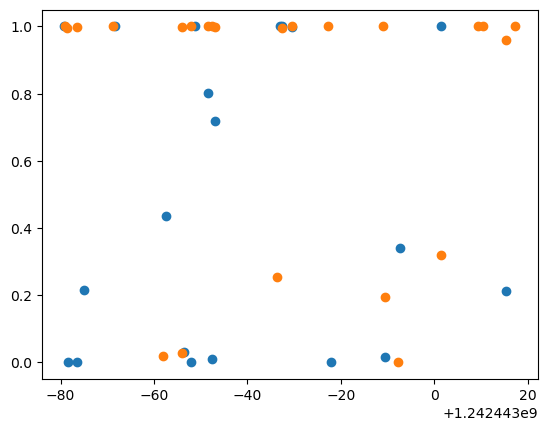

In [135]:
plt.scatter(tH1['Cluster ID'], dH1['Probability'])
plt.scatter(tL1['Cluster ID'], dL1['Probability'])

In [96]:
ytestH1, ltestH1 = predictions(dH1, modelH1)
ytestL1, ltestL1 = predictions(dL1, modelL1)

(20, 6) (20,)
(23, 6) (23,)


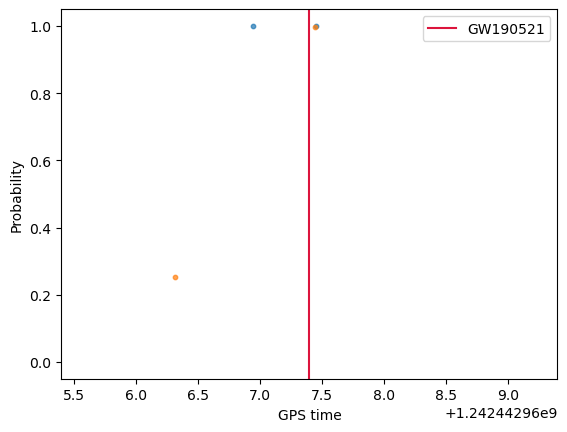

In [107]:
plt.scatter(tH1['Cluster ID'], ytestH1[:, 0], s=10,alpha=0.7)
plt.scatter(tL1['Cluster ID'], ytestL1[:, 0], s=10,alpha=0.7)
plt.axvline(1242442967.4, c='crimson', label='GW190521')
plt.xlim(1242442967.4-2, 1242442967.4+2)
plt.ylabel('Probability')
plt.xlabel('GPS time')
plt.legend()

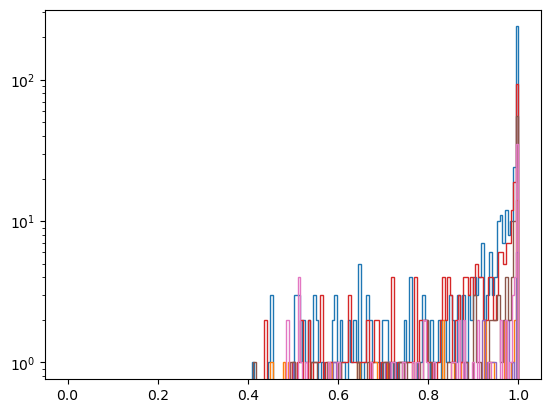

In [53]:
for i in range(7):
    plt.hist(y_pred[np.where(pred_labels == i)][:, i].detach().numpy(), histtype ='step', bins =100)
plt.yscale('log')
plt.

### O3b analysis

*Class tags*

```
if 'Injections' in file_name: t = 0

if 'Blip' in file_name: t = 1

if 'Koi_Fish' in file_name: t = 2

if 'Low_Frequency_Burst' in file_name: t = 3

if 'Tomte' in file_name: t = 4

if 'Whistle' in file_name: t = 5

if 'Fast_Scattering' in file_name:t = 6
```

In [35]:
!ls ../output_new/tw0.05/predictions

pred_known_H1_O3b.csv  pred_known_V1_O3b.csv  pred_unknown_L1.csv
pred_known_L1_O3b.csv  pred_unknown_H1.csv    pred_unknown_V1.csv


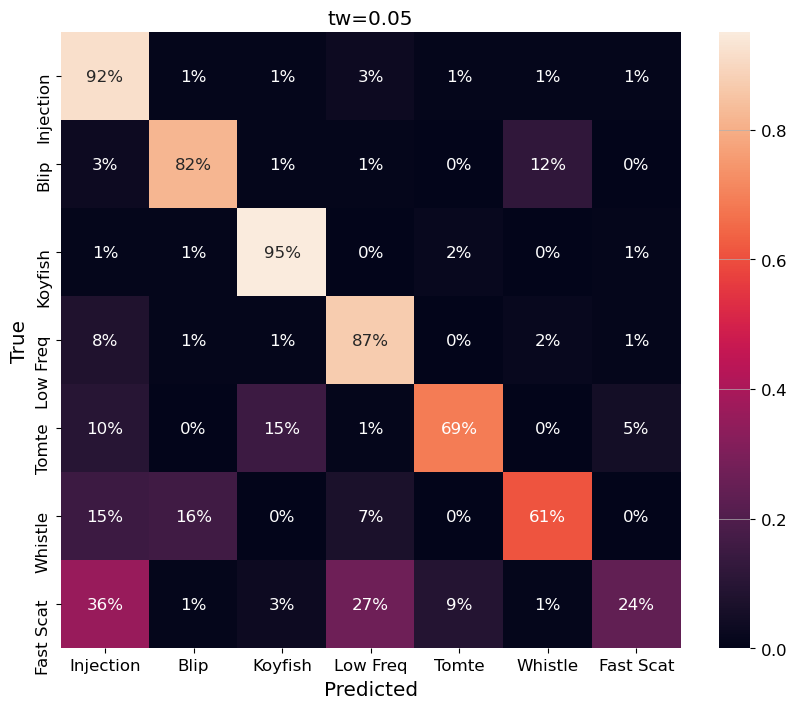

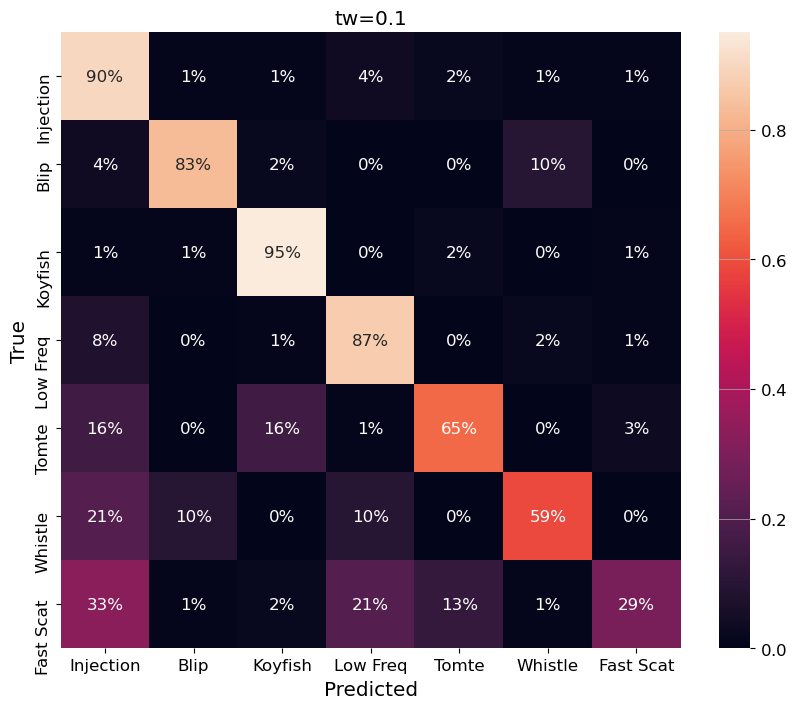

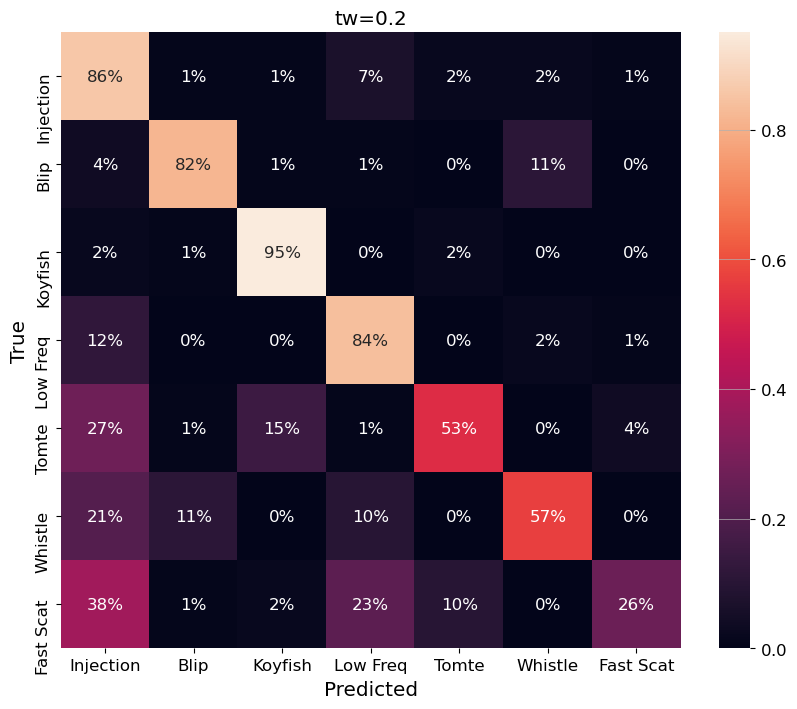

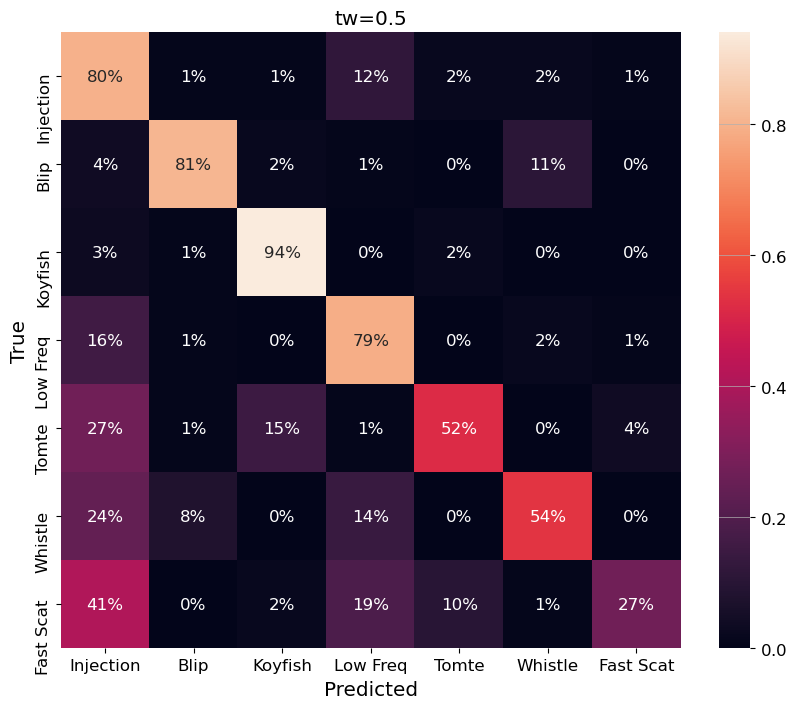

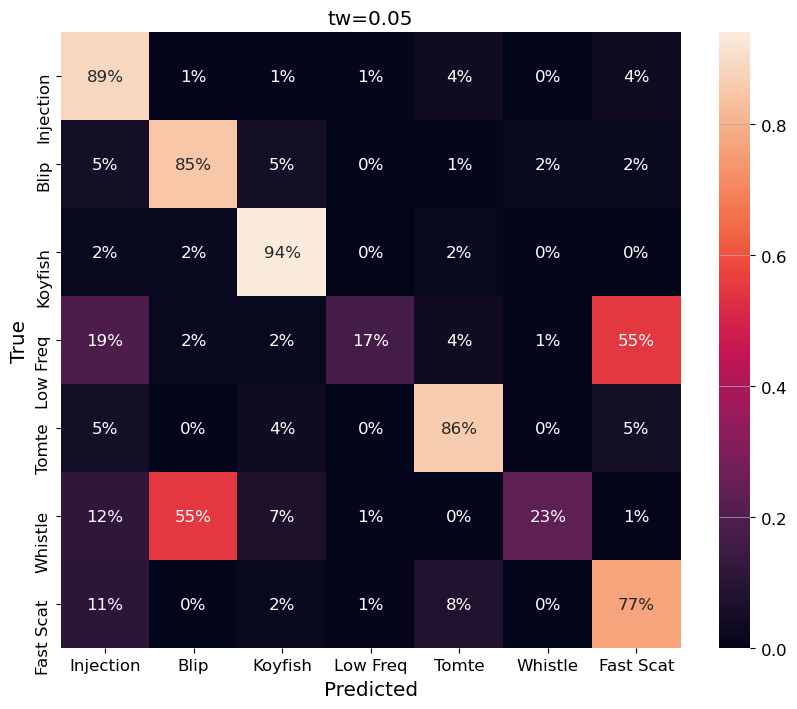

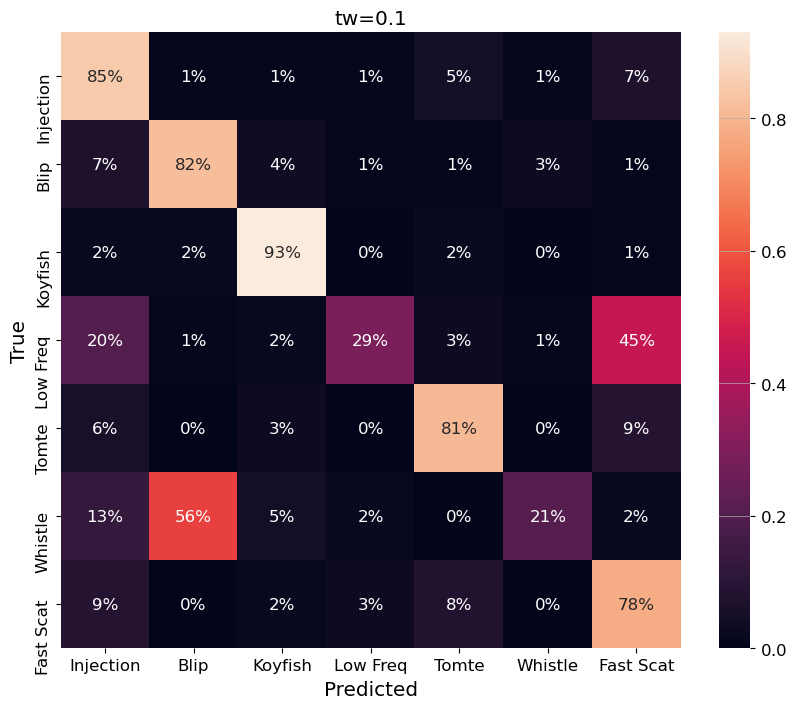

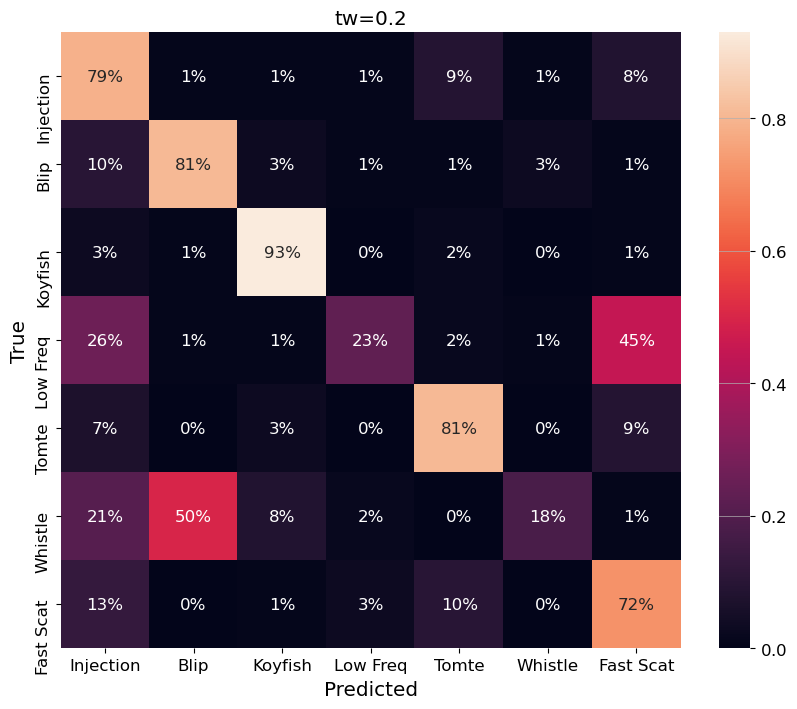

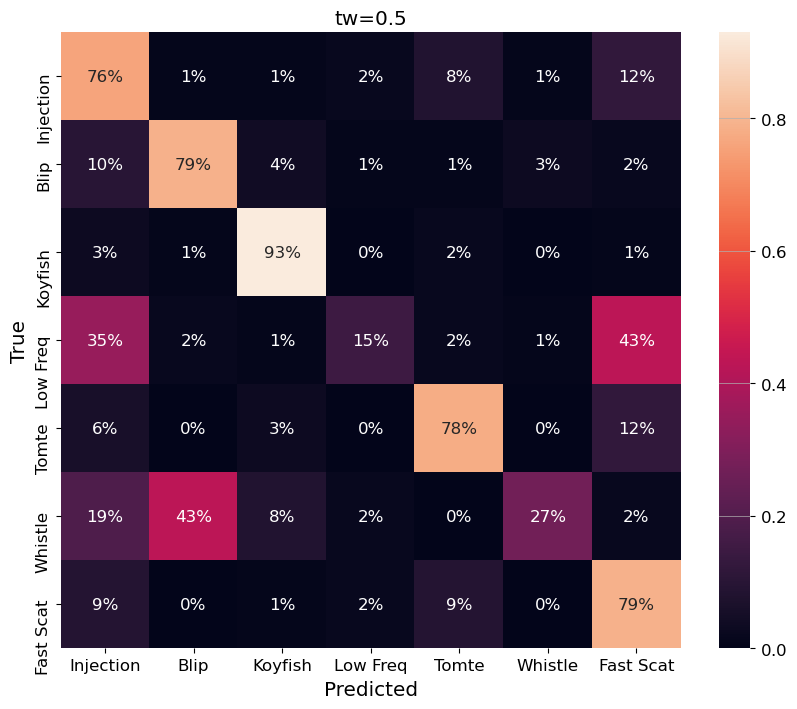

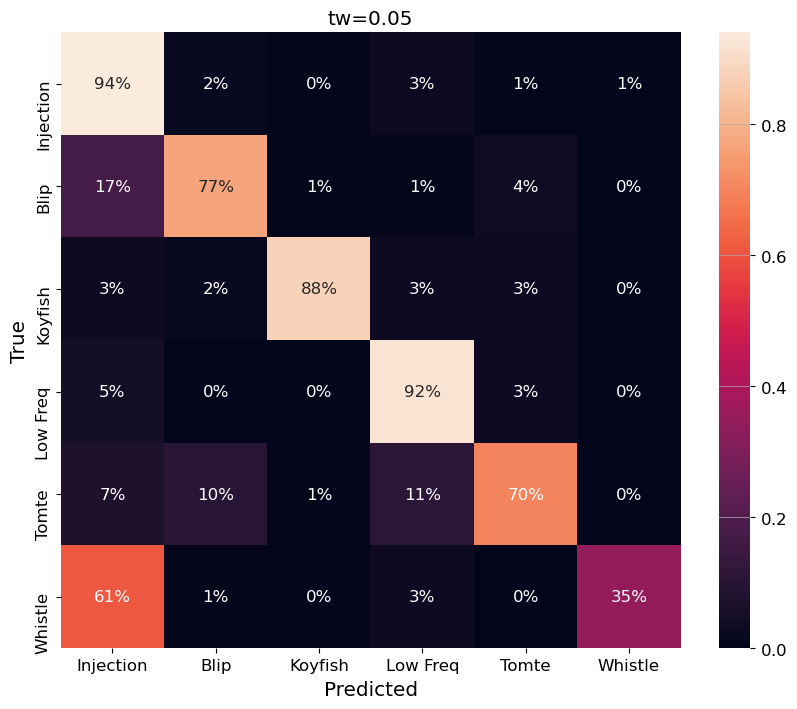

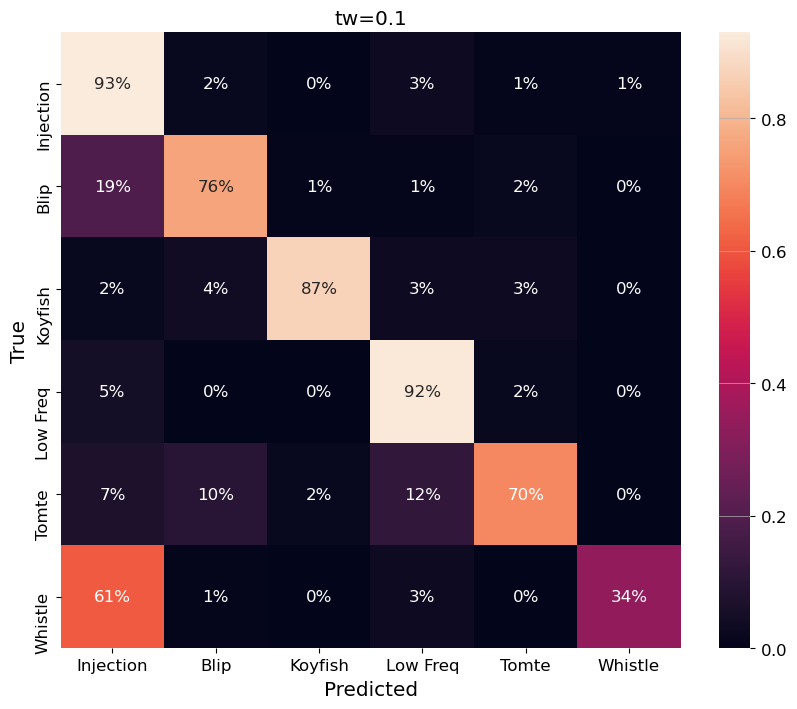

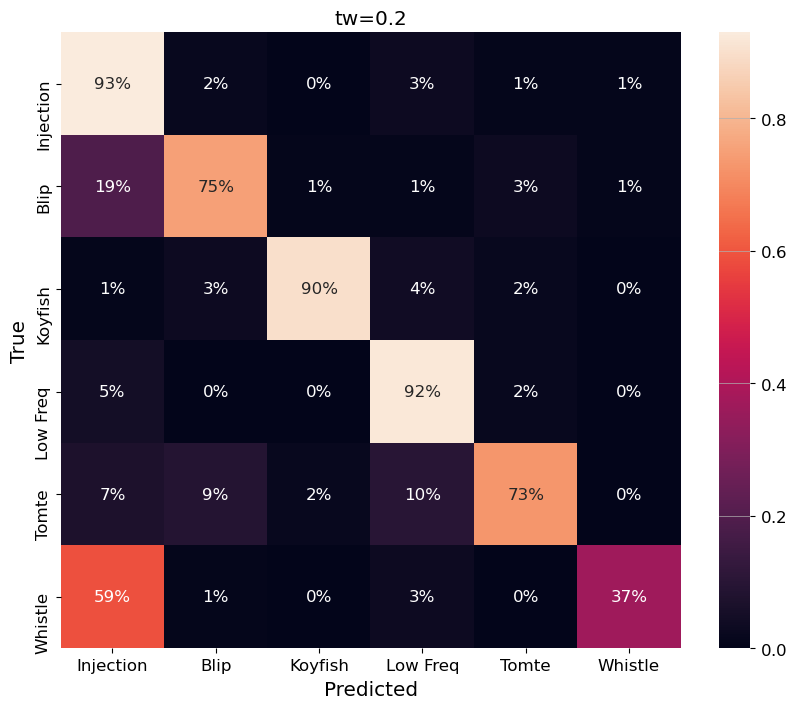

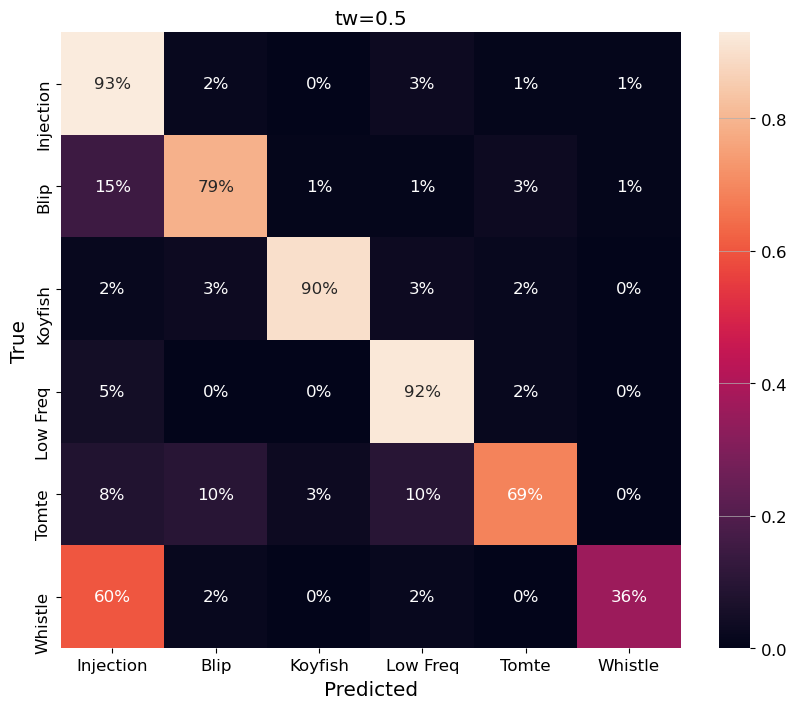

In [166]:
tw, ifo, run = 0.05, 'V1', 'O3b'
for ifo in ['H1', 'L1', 'V1']:
    for tw in [0.05, 0.1, 0.2, 0.5]:
        path = '../output_new/tw'+str(tw)+'/predictions/'
        file = 'pred_known_'+ifo+'_'+run+'.csv'
        tmp = pd.read_csv(path + file)
        tmp = tmp.loc[:, ~tmp.columns.str.match('Unnamed')]

        pred_labels = tmp.to_numpy()
        pred_labels = pred_labels[:, 7:]
        pred_labels = np.argmax(pred_labels, axis=1)
        true_labels = tmp['Class'].to_numpy()

        cfm = confusion_matrix(true_labels, pred_labels)
        cfm = np.round(cfm/np.sum(cfm, axis=1), 2)

        classes = ['Injection', 'Blip', 'Koyfish', 'Low Freq',
                   'Tomte', 'Whistle', 'Fast Scat']
        if ifo == 'V1':
            classes = classes[:-1]
        fig = plt.figure(figsize=(10, 8), dpi=100)
        sns.heatmap(cfm, annot=True, fmt=".0%")
        plt.xticks(np.arange(len(classes))+0.5, classes)
        plt.yticks(np.arange(len(classes))+0.5, classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.grid(False)
        plt.title('tw='+str(tw))
        plt.savefig('/data/gravwav/lopezm/Projects/GlitchBank/gifs/'+ifo+'/cfm_'+str(tw)+'_'+run+'.png')


In [44]:
tmp2 = tmp.loc[tmp['Class'] == 2]

Text(0, 0.5, 'Counts')

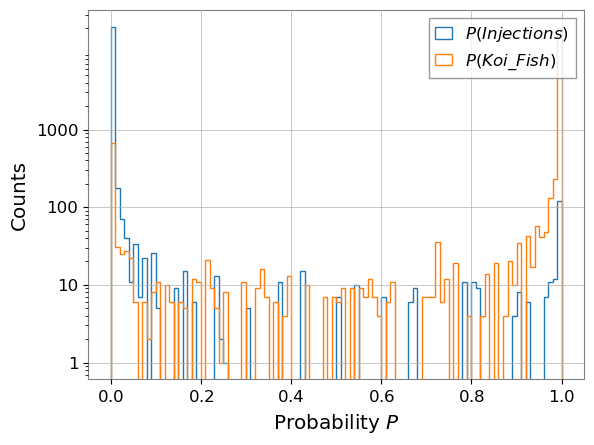

In [61]:
plt.hist(tmp2['Prob0'], density=False, bins=100,
         histtype='step', label=r'$P(Injections)$')
plt.hist(tmp2['Prob2'], density=False, bins=100,
         histtype='step', label=r'$P(Koi\_Fish)$')
plt.legend()
plt.yscale('log')
plt.yticks([1, 10, 100, 1000], [1, 10, 100, 1000])
plt.xlabel(r'Probability $P$')
plt.ylabel('Counts')

array([2., 4., 1., ..., 6., 6., 1.])

In [85]:
cfm = confusion_matrix(true_labels, pred_labels)
cfm = np.round(cfm/np.sum(cfm, axis=1), 2)

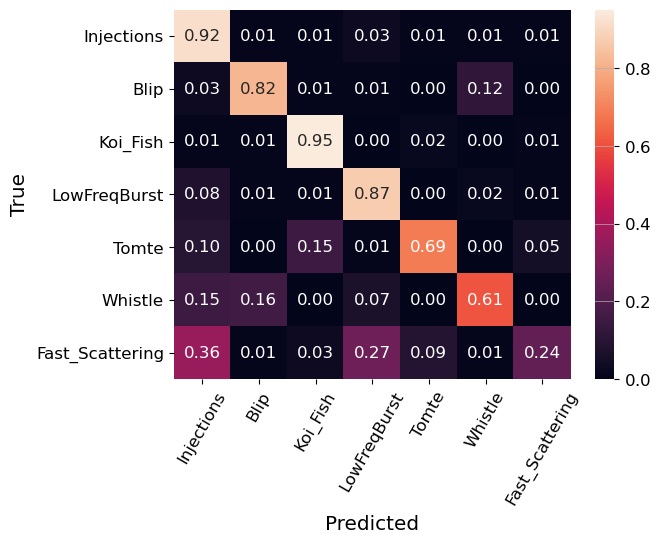

In [127]:
import os
from PIL import Image, ImageFont, ImageDraw

In [151]:
tw = 0.05
font = ImageFont.truetype("/data/gravwav/lopezm/Projects/GlitchBank/arial.ttf",25)

for ifo in ['H1', 'L1', 'V1']:
    for tw in [0.05, 0.1, 0.2, 0.5]:
        path = '/data/gravwav/lopezm/Projects/GlitchBank/computational-aspects-of-machine-learning-project-3/output_new/tw'+str(tw)+'/results/'
        for file in os.listdir(path):
            if ifo in file and file.endswith('png'):
                os.system('cp '+path+file+' /data/gravwav/lopezm/Projects/GlitchBank/gifs/'+ifo+'/cfm_'+str(tw)+'_O3a.png')
                i=Image.open('/data/gravwav/lopezm/Projects/GlitchBank/gifs/'+ifo+'/cfm_'+str(tw)+'_O3a.png')
                Im = ImageDraw.Draw(i)
                Im.text((475, 50), r"tw="+str(tw),fill=(0, 0, 0), font=font)
                i.save('/data/gravwav/lopezm/Projects/GlitchBank/gifs/'+ifo+'/cfm_'+str(tw)+'_O3a.png')

In [167]:
import glob
from PIL import Image
def make_gif(frame_folder, name):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*O3b*.png")]
    frame_one = frames[0]
    frame_one.save(name, format="GIF", append_images=frames,
               save_all=True, duration=1000, loop=0)

for ifo in ['H1', 'L1', 'V1']:
    make_gif("/data/gravwav/lopezm/Projects/GlitchBank/gifs/"+ifo,
             '/data/gravwav/lopezm/Projects/GlitchBank/gifs/'+ifo+'/cfm_'+ifo+'_O3b.gif')